# Complex source reconstruction using _starlets_ with point sources

The complex source surface brightness is solved using sparsity constrains in starlets space, and the linear amplitude of point sources (lensed quasar images) are optimized through weight least square (as in _lenstronomy_).

In [1]:
__author__ = 'aymgal'
import os
import sys
import copy
import time
import pprint
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import pysap

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Util import kernel_util

from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from slitronomy.Util.util import dirac_impulse
from slitronomy.Util.plot_util import nice_colorbar, log_cmap

%matplotlib inline


subgrid_res_source = 2
mock_psf_type = 'hst'  # 'gaussian' or 'hst'

np.random.seed(18)

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

## Generate a mock lens

In [3]:
# data specifics
num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

background_rms = 0.05  # background noise per pixel
#exp_time = 400  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)

if mock_psf_type == 'gaussian':
    psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
    psf_num_pix = 41
elif mock_psf_type == 'hst':
    psf_num_pix = 71
#psf_error_level = 0.1

In [4]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    'background_rms': background_rms,
    #'exposure_time': exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

(71, 71) 1.0


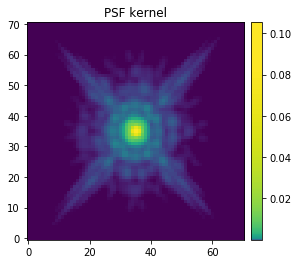

In [5]:
# PSF specification
if mock_psf_type == 'gaussian':
    psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
    psf_kernel_hd = kernel_util.kernel_gaussian(int(psf_num_pix*subgrid_res_source), 
                                                delta_pix/subgrid_res_source,
                                                psf_fwhm)
    print(psf_kernel.shape, psf_kernel_hd.shape)
if mock_psf_type == 'hst':
    with pf.open(os.path.join('data', 'psf', 'psf_tdlmc_rung0.fits')) as f:
        psf_kernel = f[0].data
    psf_kernel = kernel_util.cut_psf(psf_kernel, psf_num_pix)
    psf_kernel_hd = None
    print(psf_kernel.shape, psf_kernel.sum())
kwargs_psf = {
    'psf_type': 'PIXEL', 
    'kernel_point_source': psf_kernel,
    #'psf_error_map': psf_error_level * np.ones_like(psf_kernel)
}
psf_class = PSF(**kwargs_psf)

fig = plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 2, 1)
ax.set_title("PSF kernel")
im = ax.imshow(psf_class.kernel_point_source, origin='lower', cmap=log_cmap('viridis', 1e-4, 0.8))
nice_colorbar(im)
if 'psf_error_map' in kwargs_psf:
    ax = plt.subplot(1, 2, 2)
    ax.set_title("PSF error map")
    im = ax.imshow(psf_class.psf_error_map, origin='lower', cmap='viridis')
    nice_colorbar(im)
plt.show()

In [6]:
lens_model_list = ['SPEMD', 'SHEAR_GAMMA_PSI']
kwargs_spemd = {'theta_E': 1.8, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}
kwargs_shear = {'gamma_ext': 0.05, 'psi_ext': 0.5, 'ra_0': kwargs_spemd['center_x'], 'dec_0': kwargs_spemd['center_y']}
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
# get an pre-processed source galaxy from galsim
galsim_index = 31
snr = 500
galsim_data_path = ('/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code' +
                    '/Lens_modelling/gravlensgen/Simulations/ring_sims' +
                    '/sims_SNR{}/simring_galsim{}_all.pkl'.format(snr, galsim_index))
[data, truth, lens_model] = pkl.load(open(galsim_data_path, 'rb'))
galsim_source_highres = truth['source_galsim_3']
galsim_num_pix = data['num_pix']
galsim_delta_pix = data['delta_pix']
source_model_list = ['INTERPOL']
kwargs_interpol_source = {'image': galsim_source_highres, 'amp': 3000, 'center_x': +0.3, 'center_y': -0.1, 'phi_G': 0, 
                          'scale': galsim_delta_pix/3}
kwargs_source = [kwargs_interpol_source]
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
lens_light_model_list = []
kwargs_lens_light = [{}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# add point sources : solve lens equation from source position to find images
lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(kwargs_source[0]['center_x'], 
                                                      kwargs_source[0]['center_y'], 
                                                      kwargs_lens, numImages=4,
                                                      min_distance=delta_pix, 
                                                      search_window=num_pix*delta_pix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag_factor = 100
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
              'point_amp': mag_factor*np.abs(mag)}]
print(kwargs_ps)
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

[{'ra_image': array([ 1.93029752, -0.02402909,  1.08273339, -1.11603544]), 'dec_image': array([ 0.99330648, -1.88873789, -1.49990435,  0.66386942]), 'point_amp': array([319.18460746, 672.64513689, 611.1924482 , 127.53846172])}]


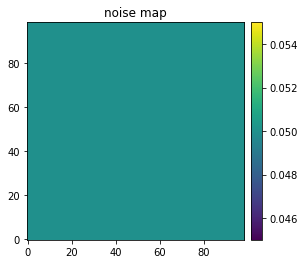

In [7]:
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}

# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class=point_source_class, 
                        kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)

bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
#poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
noise = bkg # + poisson
image_sim = image_sim_no_noise + noise
image_sim_1d = lenstro_util.image2array(image_sim)

kwargs_data['image_data'] = image_sim
if kwargs_data.get('exposure_time', None) is None:
    kwargs_data['noise_map'] = background_rms * np.ones_like(image_sim)
data_class = ImageData(**kwargs_data)

plt.title("noise map")
im = plt.imshow(np.sqrt(data_class.C_D), origin='lower')
nice_colorbar(im)
plt.show()

In [8]:
# get the light distribution in source plane
source_sim = imageModel.source_surface_brightness(kwargs_source, unconvolved=True, de_lensed=True)
source_sim_1d = lenstro_util.image2array(source_sim)

# get the light distribution in source plane convolved
source_sim_conv = imageModel.source_surface_brightness(kwargs_source, unconvolved=False, de_lensed=True)
source_sim_1d_conv = lenstro_util.image2array(source_sim)

# get the light distribution in source plane, convolved and on high res grid
if psf_kernel_hd is not None:
    from lenstronomy.ImSim.Numerics.convolution import PixelKernelConvolution
    conv_hd = PixelKernelConvolution(psf_kernel_hd, convolution_type='fft_static')
    source_sim_hd_conv = np.copy(conv_hd.convolution2d(source_sim_hd))


## Visualize the lens & true source

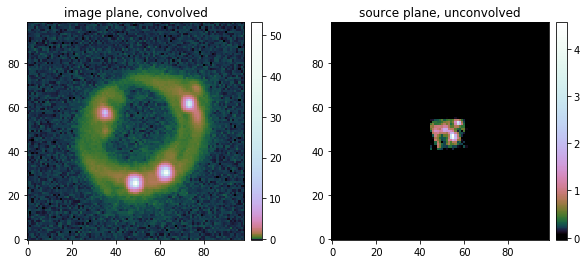

In [9]:
fig = plt.figure(figsize=(10, 4))

ax = plt.subplot2grid((1, 2), (0, 0), fig=fig)
ax.set_title("image plane, convolved")
im = ax.imshow(lin_scale(image_sim), origin='lower', cmap=log_cmap('cubehelix', 1e-3, 1))
nice_colorbar(im)

ax = plt.subplot2grid((1, 2), (0, 1))
ax.set_title("source plane, unconvolved")
im = ax.imshow(lin_scale(source_sim), origin='lower', cmap=log_cmap('cubehelix', 0.03, 1))
nice_colorbar(im)

plt.show()

## Sparse optimizazion to reconstruct the source light

In [10]:
source_model_list_sparsefit = ['STARLETS']
kwargs_starlets_source = {'n_scales': 6, 'n_pixels': np.size(image_sim)*subgrid_res_source**2}  # add center_x/center_y
kwargs_source_sparsefit = [kwargs_starlets_source]
source_model_class_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

kwargs_ps_linearfit = copy.deepcopy(kwargs_ps)
num_ps = len(kwargs_ps[0]['point_amp'])
kwargs_ps_linearfit[0]['point_amp'] = 400 + 100*np.random.randn(num_ps)   # disturb initial amplitudes

kwargs_special_sparsefit = {
    'delta_x_source_grid': 0,
    'delta_y_source_grid': 0,
}

likelihood_mask = None

kwargs_sparse_solver = {
    'source_interpolation': 'bilinear',
    'subgrid_res_source': subgrid_res_source,
    'minimal_source_plane': True,
    'min_num_pix_source': 50,
    'max_threshold': 3,
    'num_iter_source': 20,
    'num_iter_ps': 20,
    'num_iter_weights': 3,
    'verbose': True,
    'show_steps': False,
}

imageSparseFit = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                point_source_class=point_source_class,
                                likelihood_mask=likelihood_mask,
                                kwargs_sparse_solver=kwargs_sparse_solver)

In [11]:
pprint.pprint(kwargs_ps[0]['point_amp'])
pprint.pprint(kwargs_ps_linearfit[0]['point_amp'])

array([319.18460746, 672.64513689, 611.1924482 , 127.53846172])
array([256.91344024, 370.38688102, 317.85327663, 392.68497049])


In [12]:
kwargs_lens_mod = copy.deepcopy(kwargs_lens)
#kwargs_lens_mod[0]['gamma'] = kwargs_lens[0]['gamma'] * 1.1

start_time = time.time()
model, model_error, param = imageSparseFit.image_sparse_solve(kwargs_lens_mod, 
                                                       kwargs_source=kwargs_source_sparsefit,
                                                       kwargs_lens_light=None,
                                                       kwargs_ps=kwargs_ps_linearfit,
                                                       kwargs_special=kwargs_special_sparsefit)
end_time = time.time()
print("Runtime : {:.3f} s".format(end_time-start_time))

INFO : source grid has been reduced from 198 to 148 side pixels
*** iteration 0-0-0 *** : loss+reg = 3117.2760|nan, red-chi2 = 253.6118|nan, step_diff = 27.5882|nan
*** iteration 1-0-0 *** : loss+reg = 18.9724|nan, red-chi2 = 1.2490|nan, step_diff = 0.3069|nan
*** iteration 2-0-0 *** : loss+reg = 17.1339|nan, red-chi2 = 1.0839|nan, step_diff = 0.0915|nan
Runtime : 18.816 s


In [13]:
print("Updated kwargs_ps :\n", kwargs_ps_linearfit)

Updated kwargs_ps :
 [{'ra_image': array([ 1.93029752, -0.02402909,  1.08273339, -1.11603544]), 'dec_image': array([ 0.99330648, -1.88873789, -1.49990435,  0.66386942]), 'point_amp': array([317.45302427, 670.80557921, 608.38759231, 127.10592088])}]


## Plot optimization summary

Negative source pixels ? False (min = 0.00e+00)
Negative image pixels ? False (min = 3.79e-04)


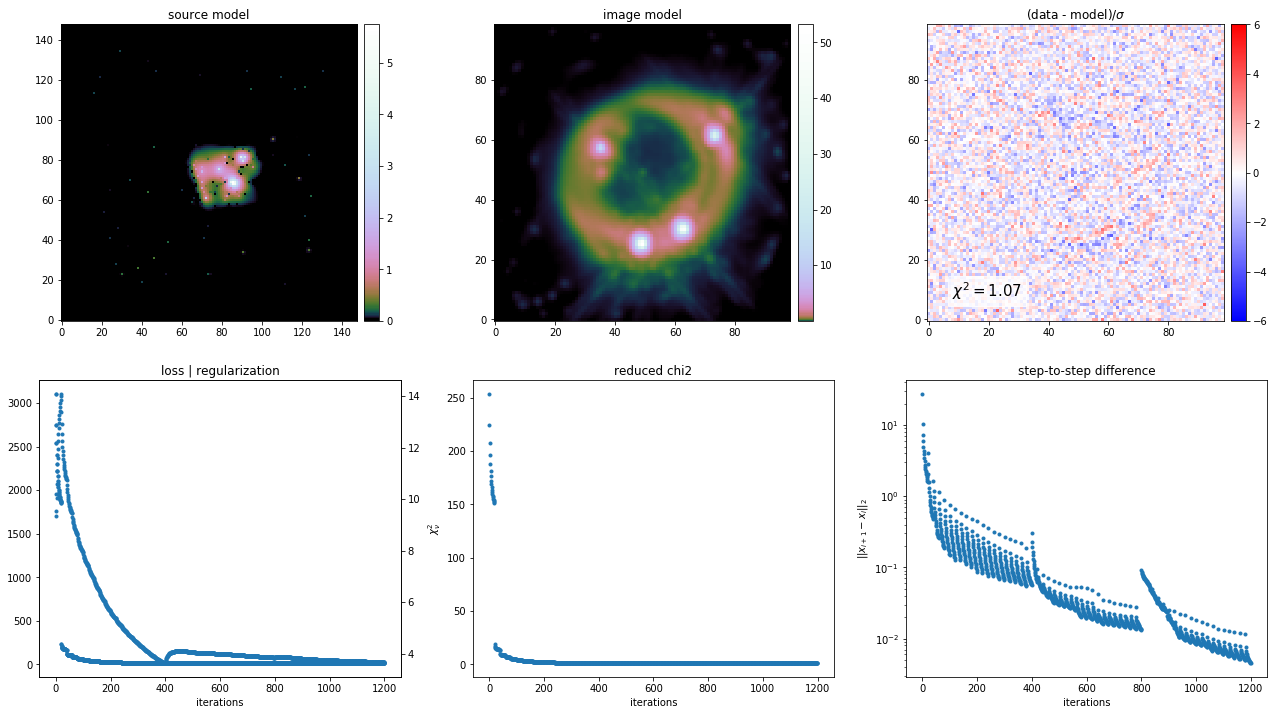

In [14]:
sparseSolver = imageSparseFit.sparseSolver
#lensingOperator = imageSparseFit.lensingOperator

fig = sparseSolver.plot_results(cmap_1=log_cmap('cubehelix', 1e-2, 1), 
                                cmap_2=log_cmap('cubehelix', 2e-4, 1))

## Plot residuals in source plane

In [15]:
# get source reconstructions
source_estimate = imageSparseFit.source_surface_brightness(kwargs_source_sparsefit, kwargs_lens=None, 
                                                           unconvolved=True, de_lensed=True)

ra_grid_hd, dec_grid_hd = lenstro_util.make_grid(numPix=num_pix, deltapix=delta_pix,
                                                 subgrid_res=subgrid_res_source)
#ra_grid_hd, dec_grid_hd = sparseSolver.lensingOperator.sourcePlane.grid()
source_estimate_hd = source_model_class_sparsefit.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source_sparsefit)
source_estimate_hd = lenstro_util.array2image(source_estimate_hd)

# get the true light distribution in source plane on high res grid
source_sim_hd = source_model_class.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source)
source_sim_hd = lenstro_util.array2image(source_sim_hd)
source_sim_hd *= (delta_pix/subgrid_res_source)**2  # unit conversion
source_sim_hd *= subgrid_res_source**2  # pixeal area ratio

model_unconvolved = imageSparseFit.source_surface_brightness(kwargs_source_sparsefit, kwargs_lens=kwargs_lens,
                                                                  unconvolved=True, de_lensed=False)

SDR = 8.271150995601694
SDR (restricted) = 8.452951480372862
SDR (HD, restricted) = 5.874619777711004
QOR = 1.0264429547209357
4.560075473785379 4.175631709396818 6.631304740905762 5.737824454903601


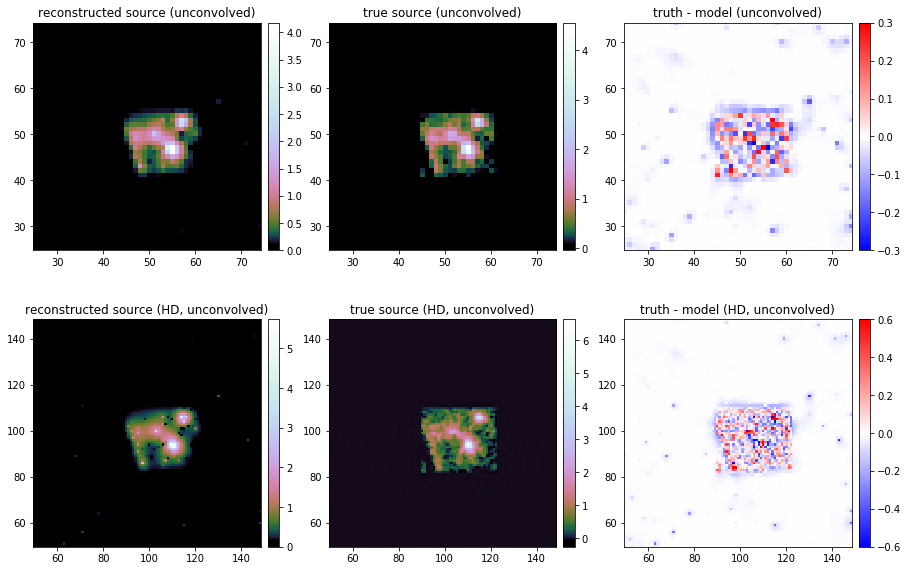

In [16]:
from metrics import SDR, QOR
print("SDR =", SDR(source_sim, source_estimate))
print("SDR (restricted) =", SDR(source_sim[33:63, 38:68], source_estimate[33:63, 38:68]))
print("SDR (HD, restricted) =", SDR(source_sim_hd[66:126, 76:136], source_estimate_hd[66:126, 76:136]))
#plt.imshow(source_sim_hd[66:126, 76:136], origin='lower')

print("QOR =", QOR(image_sim, sparseSolver.image_model(), np.sqrt(data_class.C_D)))

print(source_sim.max(), source_estimate.max(), source_sim_hd.max(), source_estimate_hd.max())
cut_level = 0.3
cut_level_hd = 0.6

residuals_source = source_sim - source_estimate
residuals_source_hd = source_sim_hd - source_estimate_hd

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

ax = axes[0, 0]
ax.set_title("reconstructed source (unconvolved)")
im = ax.imshow(source_estimate, origin='lower', cmap=log_cmap('cubehelix', 0.03, 1))
ax.set_xlim(len(source_sim)/4, 3*len(source_sim)/4)
ax.set_ylim(len(source_sim)/4, 3*len(source_sim)/4)
nice_colorbar(im)
ax = axes[0, 1]
ax.set_title("true source (unconvolved)")
im = ax.imshow(source_sim, origin='lower', cmap=log_cmap('cubehelix', 0.03, 1))
ax.set_xlim(len(source_sim)/4, 3*len(source_sim)/4)
ax.set_ylim(len(source_sim)/4, 3*len(source_sim)/4)
nice_colorbar(im)
ax = axes[0, 2]
ax.set_title("truth - model (unconvolved)")
ax.set_xlim(len(source_sim)/4, 3*len(source_sim)/4)
ax.set_ylim(len(source_sim)/4, 3*len(source_sim)/4)
im = ax.imshow(residuals_source, origin='lower', cmap='bwr', vmin=-cut_level, vmax=cut_level)
nice_colorbar(im)

ax = axes[1, 0]
ax.set_title("reconstructed source (HD, unconvolved)")
im = ax.imshow(source_estimate_hd, origin='lower', cmap=log_cmap('cubehelix', 0.03, 1))
ax.set_xlim(len(source_estimate_hd)/4, 3*len(source_estimate_hd)/4)
ax.set_ylim(len(source_estimate_hd)/4, 3*len(source_estimate_hd)/4)
nice_colorbar(im)
ax = axes[1, 1]
ax.set_title("true source (HD, unconvolved)")
im = ax.imshow(source_sim_hd, origin='lower', cmap=log_cmap('cubehelix', 0.03, 1))
ax.set_xlim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
ax.set_ylim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
nice_colorbar(im)
ax = axes[1, 2]
ax.set_title("truth - model (HD, unconvolved)")
ax.set_xlim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
ax.set_ylim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
im = ax.imshow(residuals_source_hd, origin='lower', cmap='bwr', vmin=-cut_level_hd, vmax=cut_level_hd)
nice_colorbar(im)

plt.show()